In [ ]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
from keras import backend as K 
import cv2
import pandas as pd
import ntpath
import random
import pickle

In [ ]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


total data: 4053


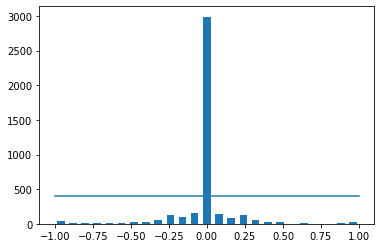

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))

removed: 2590
remaining: 1463


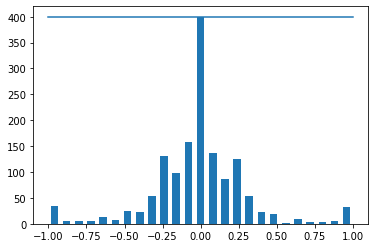

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)


center      center_2018_07_16_17_11_43_860.jpg
left        left_2018_07_16_17_11_43_860.jpg  
right       right_2018_07_16_17_11_43_860.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       0.615438                          
Name: 4, dtype: object


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3511
Valid Samples: 878


(3511,)


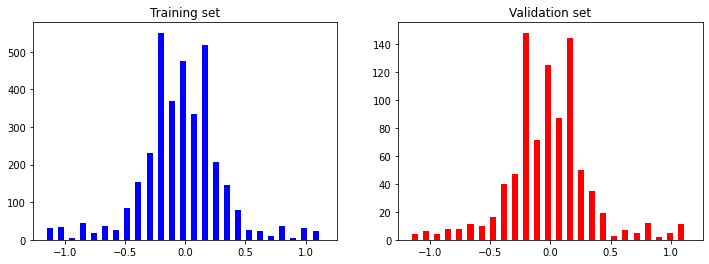

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')
print(X_train.shape)

In [ ]:
def grayscale(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img


()


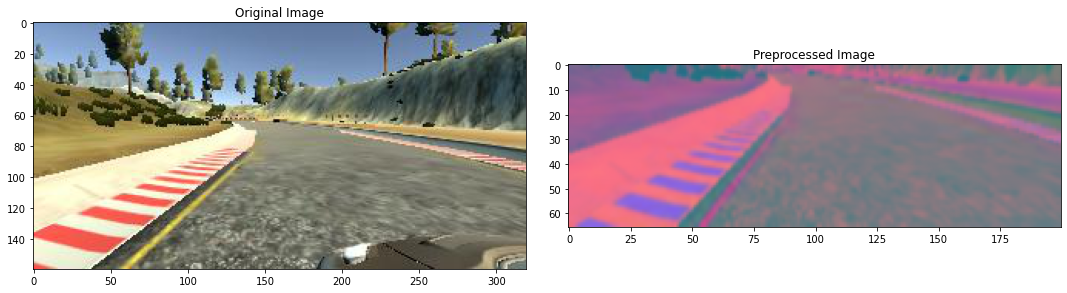

In [ ]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')
print(image_paths[5].shape)

In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

In [ ]:
print(X_train.shape)

(3511, 66, 200, 3)


In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), activation='elu'))
  model.add(Convolution2D(48, (5, 5), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [ ]:
model = nvidia_model()
print(model.summary())
print(X_train.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 196, 24)       1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 192, 36)       21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 188, 48)       43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 186, 64)       27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 184, 64)       36928     
_________________________________________________________________
dropout (Dropout)            (None, 50, 184, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 588800)            0

In [ ]:
history=model.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=10,batch_size=100,verbose=1,shuffle=1)

Epoch 1/10
36/36 [==============================] - 25s 695ms/step - loss: 8059.9312 - val_loss: 1.0611
Epoch 2/10
36/36 [==============================] - 22s 619ms/step - loss: 1.4278 - val_loss: 0.5551
Epoch 3/10
36/36 [==============================] - 22s 619ms/step - loss: 0.5287 - val_loss: 0.4496
Epoch 4/10
36/36 [==============================] - 22s 620ms/step - loss: 0.3650 - val_loss: 0.4352
Epoch 5/10
36/36 [==============================] - 22s 619ms/step - loss: 0.3631 - val_loss: 0.4633
Epoch 6/10
36/36 [==============================] - 22s 618ms/step - loss: 0.3289 - val_loss: 0.5099
Epoch 7/10
36/36 [==============================] - 22s 620ms/step - loss: 0.2920 - val_loss: 0.5215
Epoch 8/10
36/36 [==============================] - 22s 619ms/step - loss: 0.2688 - val_loss: 0.4993
Epoch 9/10
36/36 [==============================] - 22s 619ms/step - loss: 0.2445 - val_loss: 0.5254
Epoch 10/10
36/36 [==============================] - 22s 618ms/step - loss: 0.2274 - val

Text(0.5, 0, 'epoch')

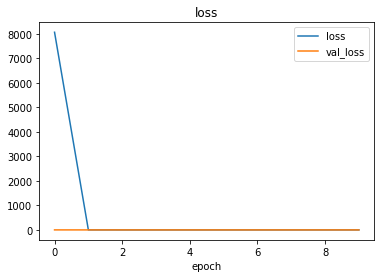

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('loss')
plt.xlabel('epoch')

In [ ]:
model.save('model.h5')

In [ ]:
from google.colab import files
files.download('model.h5')